<a href="https://colab.research.google.com/github/71762305094-ux/jf-assignment/blob/main/birds_species_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d kedarsai/bird-species-classification-220-categories

Dataset URL: https://www.kaggle.com/datasets/kedarsai/bird-species-classification-220-categories
License(s): CC0-1.0
 91% 989M/1.06G [00:10<00:01, 50.7MB/s]
100% 1.06G/1.06G [00:10<00:00, 107MB/s]


In [ ]:
dataset = '/content/bird-species-classification-220-categories.zip'

In [ ]:
#extract the zip file
import zipfile
zip_ref = zipfile.ZipFile('/content/bird-species-classification-220-categories.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# Basic utilities
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image
import cv2

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Colab specific
from google.colab import drive
from google.colab.patches import cv2_imshow  # Optional: only if you use OpenCV to show images

# Progress bars
from tqdm import tqdm

# Misc
import itertools  # for confusion matrix plotting

In [ ]:
#From the tain folder we have to put all the files in our model
#since the number of files is too big we use the concept of generator
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

class_names = train_ds.class_names

#normalization
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

Found 9414 files belonging to 200 classes.
Found 2374 files belonging to 200 classes.


In [ ]:
num_classes = len(class_names)

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load EfficientNetB0 as base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze base model layers (to use pretrained features)
base_model.trainable = False

# Build custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train (initially train only top layers)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

# Optional: Unfreeze some layers for fine-tuning (after initial training)
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # lower LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=5
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 86s 191ms/step - accuracy: 0.0047 - loss: 5.3119 - val_accuracy: 0.0051 - val_loss: 5.2987
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.0039 - loss: 5.3010 - val_accuracy: 0.0051 - val_loss: 5.2985
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.0040 - loss: 5.3001 - val_accuracy: 0.0051 - val_loss: 5.2983
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.0045 - loss: 5.2988 - val_accuracy: 0.0051 - val_loss: 5.2982
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.0043 - loss: 5.2983 - val_accuracy: 0.0051 - val_loss: 5.2982
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.0062 - loss: 5.2982 - val_accuracy: 0.0051 - val_loss: 5.2982
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.0046 - loss: 5.2982 - val_accuracy: 0.0051 - val_loss: 5.2981
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Get number of classes from the dataset
num_classes = len(class_names)

model = Sequential()

# Conv Block 1
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Conv Block 2
model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Conv Block 3
model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.0033 - loss: 5.6124 - val_accuracy: 0.0051 - val_loss: 5.4735
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 64s 92ms/step - accuracy: 0.0036 - loss: 5.3040 - val_accuracy: 0.0051 - val_loss: 5.2982
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.0026 - loss: 5.3004 - val_accuracy: 0.0055 - val_loss: 5.2969
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.0050 - loss: 5.2976 - val_accuracy: 0.0059 - val_loss: 5.2978
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.0050 - loss: 5.2934 - val_accuracy: 0.0076 - val_loss: 5.2970
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.0052 - loss: 5.2906 - val_accuracy: 0.0063 - val_loss: 5.2962
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.0071 - loss: 5.2927 - val_accuracy: 0.0042 - val_loss: 5.2974
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.0059 - loss: 5.2950 

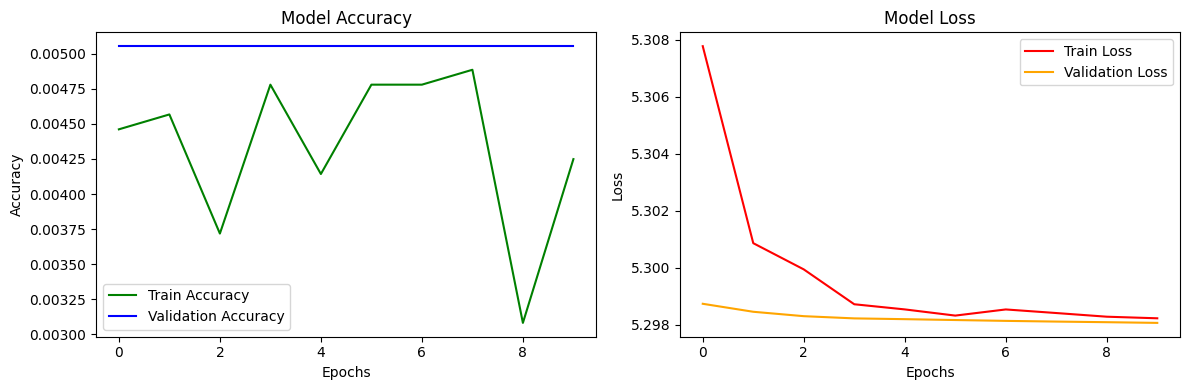

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Graph
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print(len(train_ds))
print(len(validation_ds))
for images, labels in train_ds.take(1):
    print(images.shape, labels)


295
75
(32, 256, 256, 3) tf.Tensor(
[ 29  37 158 176  99 141  96  91 146  54   1  35  75 121  30 118 115  75
 162  33  16 165  91  16  23 149  45 181  94 146 114  29], shape=(32,), dtype=int32)


In [ ]:
# Path to the test image
img_path = '/content/bird1.jpg'  # Change to your image path

# Load and preprocess image
img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)


In [ ]:
# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])  # Get the highest probability class
predicted_class = class_names[predicted_class_index]
confidence = np.max(predictions[0]) * 100

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


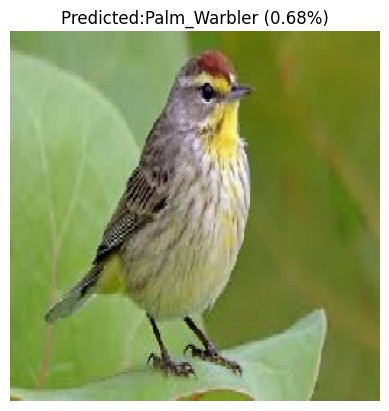

In [ ]:
# Show the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted:{class_names[predicted_class_index]} ({confidence:.2f}%)')
plt.show()

In [ ]:
# Path to the test image
img_path = '/content/bird2.jpg'  # Change to your image path

# Load and preprocess image
img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension


In [ ]:
# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])  # Get the highest probability class
#predicted_class = class_names[predicted_class_index]
confidence = np.max(predictions[0]) * 100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


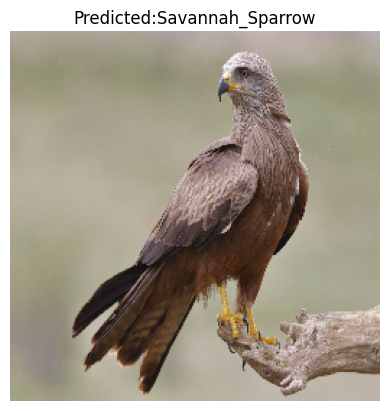

In [ ]:
# Show the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted:{class_names[predicted_class_index]}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


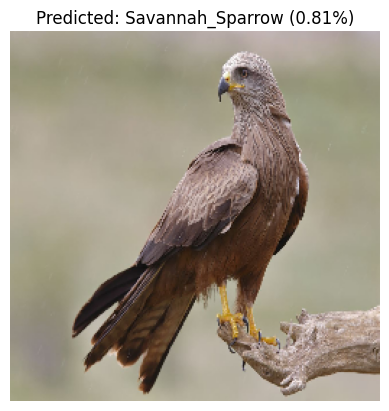

KeyboardInterrupt: Interrupted by user

In [ ]:
# --- Interactive Feedback Loop ---
def feedback_loop(img_path, model, class_names, feedback_dir="/content/feedback"):
    # Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = np.max(predictions[0]) * 100

    # Show prediction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    # Ask user for feedback
    user_input = input(f"Is this prediction correct? (yes/no): ").strip().lower()

    if user_input == "yes":
        print("Great! The prediction was correct.")
    else:
        print(" Prediction was wrong.")
        correct_class = input(f"Please enter the correct class from {class_names}: ").strip()

        if correct_class in class_names:
            # Save feedback image into feedback dataset
            save_dir = os.path.join(feedback_dir, correct_class)
            os.makedirs(save_dir, exist_ok=True)
            img.save(os.path.join(save_dir, os.path.basename(img_path)))
            print(f"📌 Saved to feedback dataset under class: {correct_class}")
        else:
            print("⚠️ Invalid class name entered. Skipping.")

# Example usage:
feedback_loop("/content/bird2.jpg", model, class_names)
